# Task B: Hardness Prediction

Predicting the difficulty of a question, ranging from 1 (being easy) to 10 (being difficult), using the available features.

### Import necessary libraries.

In [12]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import linear_model
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso as lasso
import plotly.express as px

### Import data

In [14]:
df = pd.read_json(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip")

topic_and_hardness = pd.read_json(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip")

prompt_embeddings = pd.DataFrame(np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-prompts-embeddings.npy"))

response_a_embeddings = pd.DataFrame(np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_a_response-embeddings.npy"))

response_b_embeddings = pd.DataFrame(np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_b_response-embeddings.npy"))

# Get top 10 most frequently occuring topics as features without losing rows nor creating NaN values.

In [16]:
# Select top 10 most frequently occuring topics 
encode_topics = topic_and_hardness['topic_modeling_1'].value_counts().head(10).index

# Create a dictionary to map topics to an integer + an integer for topics not frequently occuring. 
indexes = [i for i in range(len(encode_topics))]
encoded_10_topics = dict(zip(encode_topics, indexes))
encoded_10_topics['NOT_FREQUENT'] = 10

# Create column that is almost identical to 'topic_modeling_1' except, rename all topics that are not in the top 10 as "NOT_FREQUENT". 
topic_and_hardness['topic_modeling_1_preprocessed'] = topic_and_hardness['topic_modeling_1'].where(topic_and_hardness['topic_modeling_1'].isin(encode_topics), 'NOT_FREQUENT')

# Create column that maps the topic in 'topic_modeling_1_preprocessed' column to an integer. 
topic_and_hardness['topic_mapped'] = topic_and_hardness['topic_modeling_1_preprocessed'].map(encoded_10_topics)

# One-hot encode the top 10 most frequently occurring topics + the non-frequent topics. 
one_hot_encoded_10_topics = pd.get_dummies(topic_and_hardness["topic_mapped"]).astype(int)

# merge the new one-hot-encoded features with topic_and hardness dataframe. 
topic_and_hardness_top10_topics = pd.merge(topic_and_hardness,one_hot_encoded_10_topics, left_index=True, right_index=True)

# Clean up the invalid non-NaN values

In [18]:
def take_out_list(one_series_element):
    '''
    Input: one_series_element is a single string element or a nested list.
    Output: one_series_element or the nested item in the one_series_element if one_series_element is a list. 
    '''
    if isinstance(one_series_element, list):
        return one_series_element[0][0]
    else:
        return one_series_element

In [19]:
score_value_1_cleaned = topic_and_hardness["score_value_1"].apply(take_out_list)
score_value_2_cleaned = topic_and_hardness["score_value_2"].apply(take_out_list)
score_value_3_cleaned = topic_and_hardness["score_value_3"].apply(take_out_list)
topic_and_hardness["score_value_1"] = score_value_1_cleaned
topic_and_hardness["score_value_2"] = score_value_2_cleaned
topic_and_hardness["score_value_3"] = score_value_3_cleaned

# Find 50 clusters in embeddings using K-means clustering

In [21]:
cluster_features = pd.DataFrame()
n_clusters = 50

In [22]:
# Assigning each embedded row in prompt_embeddings to 1 of 50 clusters. 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(prompt_embeddings)
# Create new feature/column for prompt clusters. 
cluster_features["prompt_cluster"] = kmeans.predict(prompt_embeddings)

# Assigning each embedded row in response_a_embeddings to 1 of 50 clusters. 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(response_a_embeddings)
# Create new feature/column for response a clusters. 
cluster_features["response_a_cluster"] = kmeans.predict(response_a_embeddings)

# Assigning each embedded row in response_b_embeddings to 1 of 50 clusters. 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(response_b_embeddings)
# Create new feature/column for response b clusters. 
cluster_features["response_b_cluster"] = kmeans.predict(response_b_embeddings)

# DROP ROWS IN ALL DATASETS AT ROW INDICES WHERE MISSING VALUES ARE FOUND IN ROWS OF topic_and_hardness dataframe.

In [24]:
nan_rows = topic_and_hardness[topic_and_hardness.isna().any(axis=1)]
nan_indices = nan_rows.index.tolist()

cluster_features.drop(nan_indices, inplace=True)
one_hot_encoded_10_topics.drop(nan_indices, inplace=True)
topic_and_hardness.drop(nan_indices, inplace=True)
prompt_embeddings.drop(nan_indices, inplace=True)
response_a_embeddings.drop(nan_indices, inplace=True)
response_b_embeddings.drop(nan_indices, inplace=True)

# FEATURE ENGINEER HARDNESS SCORE.
Averageing the individual 3 hardness scores and rounding them to the nearest integer helped simplify model training and prevent over-fitting.

In [26]:
def rounding(series_element):
    '''
    Input: an element in a series of floats.
    Output: integer that was rounded to the nearest integer from the input. 
    '''
    decimal_part = series_element - int(series_element)
    if decimal_part >= 0.5:
        return math.ceil(series_element)
    else:
        return math.floor(series_element)

In [27]:
# Feature engineer: average_hardness_score
topic_and_hardness['average_hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)

# Feature engineer: discrete values of average_hardness_score
topic_and_hardness['rounded_average_hardness_score'] = topic_and_hardness['average_hardness_score'].apply(rounding)

# CREATE DESIGN MATRIX.
We incorporated cluster features from K-Means, one-hot-encoded topics, and prompt embeddings into the design matrix. 
We incorporated prompt embeddings because it was the most influential feature that determined the hardness score. 

In [29]:
# Creating design matrix
X = pd.concat([cluster_features, one_hot_encoded_10_topics, prompt_embeddings],axis=1)

# Convert column names to be the same type to avoid syntax error during training. 
X.columns = X.columns.astype(str)

# SPLIT DATA 80/20 FOR TRAINING AND VALIDATION SET. 

In [31]:
# Split into train and validation set 

Y = topic_and_hardness["rounded_average_hardness_score"]
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=11)

# MODEL TRAINING.
We chose a linear regression model to determine the hardness score of prompts since the final test set contains the hardness score as a continuous numerical variable.
We chose our target variable to be integers rounded from continuous numerical variables to simplify training purposes. 

In [33]:
# instatiate linear model
TASKB_lm = LinearRegression(fit_intercept = True)

# train model
TASKB_lm.fit(X_train , y_train)

# make predictions
training_predictions = TASKB_lm.predict(X_train)
validing_predictions = TASKB_lm.predict(X_valid.values)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# EVALUATE MODEL.

We chose to evaluate the model with mean squared error (mse), as that is considered the loss function used to measure the differences in actual vs. predicted values for linear regression. We also used r^2 as an evaluation metric to understand how well our model captures the variability in our data. Hyperparameters that were adjusted were 

In [35]:
def mse(actual_y, predicted_y):
    """
    Args:
        predicted_y: An array of the predictions from the model.
        actual_y: An array of the ground truth labels.
        
    Returns:
        The mean square error between the predictions and ground truth labels.
    """
    diff_sq = (actual_y - predicted_y)**2
    summation = np.sum(diff_sq)
    avg = summation/(len(diff_sq))
    return avg

In [36]:
# Calculating mse of training and validation sets
print(f'training mse: {mse(y_train, training_predictions)}')
print(f'validation mse: {mse(y_valid, validing_predictions)}')
# Calculating r^2
print(f'R^2: {r2_score(y_train, training_predictions)}')

training mse: 1.9154969570248466
validation mse: 1.970335752847665
R^2: 0.36622430807863027


# We also tried to improve our model with Lasso regression, but this actually made our model worse, and we did not use it for the final gradescope test submission. 

Below visualizes the hyperparameter lambda that we tried to change in hopes of finding a value that would help generalize our model. 
Because no improvement was shown, we chose not to use Lasso Regression for the final submission.

Please note: The cell below for lasso regression takes a very long time to run. Therefore, it is commented out because we did not include it in our final submission and it takes a long time to run.

In [38]:
# error_vs_lambda = pd.DataFrame(columns = ["lambda", "Training Error", "Validation Error"])
# range_of_lambda = 10**np.linspace(-5, 4, 40)

# for lamb in range_of_lambda:
#     regularized_model_lambda = lasso(lamb)
#     regularized_model_lambda.fit(X_train, y_train)
#     train_error_overfit = mse(y_train, regularized_model_lambda.predict(X_train))
#     holdout_error_overfit = mse(y_valid, regularized_model_lambda.predict(X_valid))
#     error_vs_lambda.loc[len(error_vs_lambda)] = [lamb, train_error_overfit, holdout_error_overfit]

# error_vs_lambda.head()
# px.line(error_vs_lambda, x = "lambda", y = ["Training Error", "Validation Error"], log_x=True, height = 400, width = 800)

# Visualize performance.

Initially, we used a scatter plot to visualize performance since a linear regression model should be used to predict continuous data. However, we faced over-plotting issues and decided to use a box-plot to visualize performance. The box-plot works in our favor to also visualize the distribution of predicted scores for every rounded hardness score.

In [41]:
# Commented out scatter plot
# # Visualizing actual vs. predicted values using scatter plot.
# plt.figure(figsize=(6,6))
# plt.scatter(y_train, training_predictions, alpha=0.6)
# plt.title('Predicted hardness scores\nvs.\nActual average hardness scores (rounded)')
# plt.xlabel('Actual average hardness scores (rounded)')
# plt.ylabel("Predicted hardness scores")
# plt.grid(True)
# plt.show()

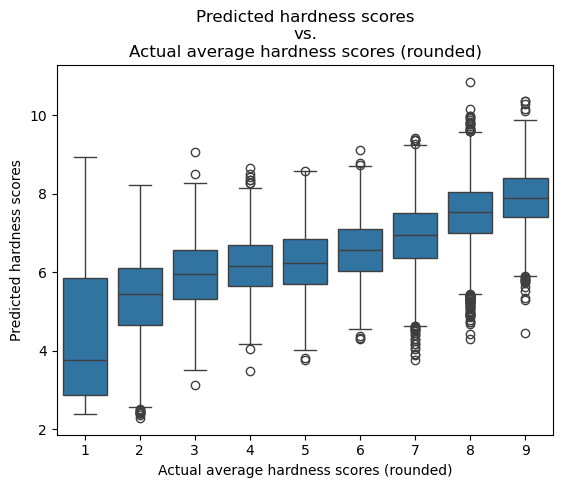

In [42]:
# Visualizing actual vs. predicted values using box plot.
sns.boxplot(x=y_train, y=training_predictions)
plt.title('Predicted hardness scores\nvs.\nActual average hardness scores (rounded)')
plt.xlabel('Actual average hardness scores (rounded)')
plt.ylabel("Predicted hardness scores")
# plt.savefig('figure19.png', format='png')
plt.show()

# Additional evaluation metrics. 
After visualizing the box plot above, we thought of another way to measure performance by taking the rows, averaging each true hardness score found between 1 to 10 , and average their row's predicted hardness score, and taking the absolute differences between the averages. 

In [44]:
# Create new dataframe of just true and predicted values.
y_values = pd.DataFrame({"avg y": y_train, "avg y^": training_predictions})
print("Average y^hat prediction \nper true hardness score:")
y_values.groupby("avg y").agg("mean")
differences = pd.DataFrame(y_values.groupby("avg y").agg("mean"))
differences.reset_index(inplace=True)
differences["abs(avg y - avg y^)"] = np.abs(differences["avg y"] - differences["avg y^"])
differences

Average y^hat prediction 
per true hardness score:


,avg y,avg y^,abs(avg y - avg y^)
0,1,4.290678,3.290678
1,2,5.352494,3.352494
2,3,5.950883,2.950883
3,4,6.188189,2.188189
4,5,6.258751,1.258751
5,6,6.568172,0.568172
6,7,6.920632,0.079368
7,8,7.497919,0.502081
8,9,7.893665,1.106335


### To ensure a comprehensive evaluation, we also measured mean squared error 10 times with 10 different 80/20 splits in our training data using k-fold cross validation to ensure our evaluation metrics were not due to randomness of initial splits in our data. 

In [46]:
def compute_CV_error(model, X_train, Y_train):
    '''
    Split the training data into 10 subsets.
    For each subset, 
        - Fit a model holding out that subset.
        - Compute the MSE on that subset (the validation set).

    Args:
        model: An sklearn model with fit and predict functions. 
        X_train (DataFrame): Training data.
        Y_train (DataFrame): Label.
    
    Return:
        The average validation MSE for the 10 splits.
    '''
    kf = KFold(n_splits=10)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx] 
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx] 

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the MSE on the validation split
        error = mse(split_Y_valid, model.predict(split_X_valid))

        validation_errors.append(error)
        
    return np.mean(validation_errors), validation_errors

In [47]:
mean_mse, fold_errors = compute_CV_error(LinearRegression(fit_intercept=True), X_train, y_train)
print(f'Average loss: {mean_mse}')

Average loss: 1.9726546170991206


# Plotting our validation mse of each fold in our cross-validation of k=10. 

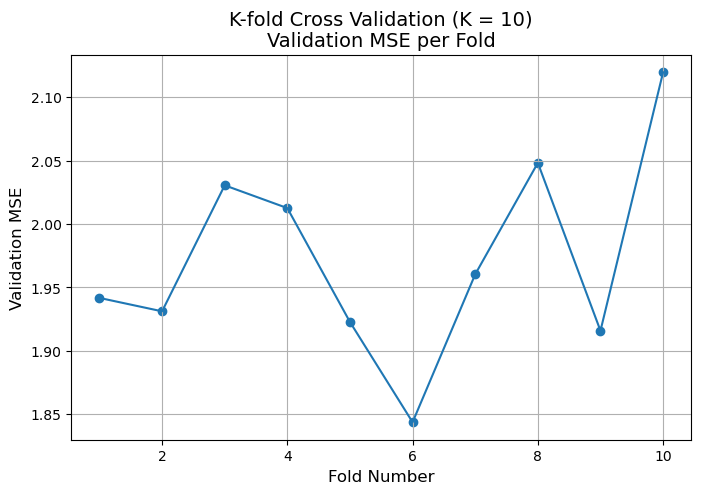

In [49]:
plt.figure(figsize=(8,5))
plt.scatter(range(1, 11), fold_errors)
plt.plot(range(1, 11), fold_errors)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Validation MSE', fontsize=12)
plt.title('K-fold Cross Validation (K = 10)\nValidation MSE per Fold', fontsize=14)
plt.grid(True)
plt.show()

# USING TEST SETS

In [51]:
# Hold out sets:

df = pd.read_json(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-prompt-and-responses.jsonl.gz",
    lines=True,
    compression="gzip")

topic_and_hardness = pd.read_json(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-topic-modeling.jsonl.gz",
    lines=True,
    compression="gzip")

prompt_embeddings = pd.DataFrame(np.load(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-prompts-embeddings.npy"))

response_a_embeddings = pd.DataFrame(np.load(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-model_a_response-embeddings.npy"))

response_b_embeddings = pd.DataFrame(np.load(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-model_b_response-embeddings.npy"))

# Get top 10 most frequently occuring topics as features without losing rows nor creating NaN values.

In [53]:
# Select top 10 most frequently occuring topics 
encode_topics = topic_and_hardness['topic_modeling_1'].value_counts().head(10).index

# Create a dictionary to map topics to an integer + an integer for topics not frequently occuring. 
indexes = [i for i in range(len(encode_topics))]
encoded_10_topics = dict(zip(encode_topics, indexes))
encoded_10_topics['NOT_FREQUENT'] = 10

# Create column that is almost identical to 'topic_modeling_1' except, rename all topics that are not in the top 10 as "NOT_FREQUENT". 
topic_and_hardness['topic_modeling_1_preprocessed'] = topic_and_hardness['topic_modeling_1'].where(topic_and_hardness['topic_modeling_1'].isin(encode_topics), 'NOT_FREQUENT')

# Create column that maps the topic in 'topic_modeling_1_preprocessed' column to an integer. 
topic_and_hardness['topic_mapped'] = topic_and_hardness['topic_modeling_1_preprocessed'].map(encoded_10_topics)

# One-hot encode the top 10 most frequently occurring topics + the non-frequent topics. 
one_hot_encoded_10_topics = pd.get_dummies(topic_and_hardness["topic_mapped"]).astype(int)

# merge the new one-hot-encoded features with topic_and hardness dataframe. 
topic_and_hardness_top10_topics = pd.merge(topic_and_hardness,one_hot_encoded_10_topics, left_index=True, right_index=True)

# Find 50 clusters in test embeddings using K-means clustering

In [55]:
cluster_features = pd.DataFrame()

In [56]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(prompt_embeddings)
cluster_features["prompt_cluster"] = kmeans.predict(prompt_embeddings)

In [57]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(response_a_embeddings)
cluster_features["response_a_cluster"] = kmeans.predict(response_a_embeddings)

In [58]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(response_b_embeddings)
cluster_features["response_b_cluster"] = kmeans.predict(response_b_embeddings)

# Create design matrix and predict hardness score for final predictions.

In [60]:
X = pd.concat([cluster_features, one_hot_encoded_10_topics, prompt_embeddings],axis=1)
X.columns = X.columns.astype(str) # convert all column names to string to avoid syntax error.

# Make final predictions. 

In [62]:
FINAL_PREDICTIONS = TASKB_lm.predict(X)

# Export hardness score predictions to combine with TASK A.

In [64]:
FINAL_PREDICTIONS = pd.DataFrame(FINAL_PREDICTIONS)
FINAL_PREDICTIONS.to_csv("data/PREDICTED_HARDNESS_SCORES.CSV")

# COMBINE WITH TASK A + PUT CSV IN PROPER FORMAT FOR GRADESCOPE SUBMISSION.

In [66]:
FINAL_PREDICTIONS = FINAL_PREDICTIONS.rename(columns = {0:"hardness_score"})

Task_A_predictions = pd.read_csv("data/output.csv")
Task_A_predictions = Task_A_predictions[["question_id", "winner"]]

GRADESCOPE_SUBMISSION = pd.concat([Task_A_predictions, FINAL_PREDICTIONS], axis =1)
GRADESCOPE_SUBMISSION = GRADESCOPE_SUBMISSION.set_index("question_id")

GRADESCOPE_SUBMISSION.to_csv("data/GRADESCOPE_SUBMISSION.csv")

Which model(s) do you use and why?


    I used a linear regression model as it returns a continuous prediction


How do you use your data for training and testing?


    I spilt the training data set .80/.20 training/validation then use 10 fold Cross validation


Does your model require hyperparameter tuning? If so, how do you approach it?


    I tried to improve our model with Lasso regression and tuning the hyperparameter lambda, but this actually made our model worse, and I did not use Lasso regression for the final gradescope test submission. I did tune the number of k clusters we used and found 50 clustered the embeddings nicely based on our EDA. 


How do you engineer the features for your model? What are the rationales behind selecting these features?


    I one-hot encoded the top 10 most frequently occuring topics because they are categorical variables. 
    I also performed K-means clustering to assign each embedded row in the embedded dataset to 1 of 50 clusters.
    I also averaged the hardness scores 1, 2, and 3; and rounded them to the nearest integer to simplify training purposes and quantify error.
    These features were selected because the hardness score was being determined for prompts/topics that  were being answered by the chatbots (whose conversations were embedded).


How do you perform cross-validation on your model?


    I used 10 fold cross validation using the training data set. Each split was done 80% for training and 20% for validation. 


What loss metrics are you using to evaluate your model? Why?


    I am using mean squared error for my loss metric because I am performing a linear regression to predict continuous values and the true labels are also continuous values.
    I also included the absolute difference between each true average hardness score rounded to the nearest integer, and the average of their predicted values as another way
    to evaluate the model since we had initially rounded the average hardness scores to their nearest integer. 


From a bias-variance tradeoff standpoint, how do you assess the performance of your model? How do you check if it is overfitting?


    I used cross validation and compard r^2 values of my different 3 models to measure variability. 
    Since variability was relatively low across all 3 models (i.e. <0.5), it is assumed there is high bias due to the bias-variance tradeoff. 


How would you improve your model based on the outcome?


    add more data with prompts that are truly considered easy with hardness scores less than 5. 


Are there any further extensions to your model that would be worth exploring?


    Adding different clustering algorithms like DBSCAN or UMAP instead of PCA to capture and visualize clustered embeddings. Perhaps feed the data into a deep neural network. 